# Stacking Model

In the previous notebooks, I have built different models. In this notebook, I will use the three best ones in the Stacking Model in order to try and improve F1 and Accuracy and combat overfitting.

---

In [2]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Import my custom functions for fitting and scoring models, tokenizing, and plotting residuals.
import functions_for_modeling

In [3]:
# Read the data
reddit = pd.read_csv('../data/reddit_cleaned_removed_words.csv')

In [4]:
# Split the data
X = reddit['all_text']
y = reddit['subreddit_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 18,  stratify = y)

---

## Stacking

In [13]:
# Fit with three best models Naive Bayes, Gradient Boosting, and XGBoost using hyperparameters from the best models found in previous notebooks.

level1_estimators = [
    ('nb', MultinomialNB(alpha=0.8)),
    ('xgb', XGBClassifier(subsample=0.9, reg_alpha=0.4, max_depth=5, learning_rate=0.14, gamma=0.28, colsample_bytree=0.73)),
    ('gb', GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate= 0.12)),
    
]

pipe_staking = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english')),
    ('staking', StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression()))
])

pipe_params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [2, 3, 4, 5],
    'cvec__max_df': [0.8, 0.9, 0.95],
    'staking__final_estimator__C': np.linspace(0.01, 1, 15),
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=18)

st = RandomizedSearchCV(pipe_staking, 
                       param_distributions = pipe_params,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=40)

In [12]:
st = functions_for_modeling.model_fit_scores(st, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8911894814450726
Best Parameters: {'staking__final_estimator__C': 1.0, 'cvec__min_df': 2, 'cvec__max_features': 5000, 'cvec__max_df': 0.8}
Train accuracy: 0.9622279129321383
Test accuracy: 0.9040307101727447
F1 score: 0.8466257668711656


This model performs better than my previous best model - Naive Bayes. I will try to improve it even more by adding Ada Boost.

---

In [14]:
# Fit with all four models using hyperparameters from the best models found in previous notebooks.

level1_estimators_all = [
    ('nb', MultinomialNB(alpha=0.8)),
    ('xgb', XGBClassifier(subsample=0.9, reg_alpha=0.4, max_depth=5, learning_rate=0.14, gamma=0.28, colsample_bytree=0.73)),
    ('gb', GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate= 0.12)),
    ('ada', AdaBoostClassifier(n_estimators=300, learning_rate= 0.13, base_estimator=DecisionTreeClassifier()))
    
]

pipe_staking_all = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english')),
    ('staking', StackingClassifier(estimators=level1_estimators_all,
                                 final_estimator=LogisticRegression()))
])


st_all = RandomizedSearchCV(pipe_staking_all, 
                       param_distributions = pipe_params,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=40)

In [15]:
st_all = functions_for_modeling.model_fit_scores(st_all, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8931105103629065
Best Parameters: {'staking__final_estimator__C': 0.4342857142857143, 'cvec__min_df': 2, 'cvec__max_features': 4000, 'cvec__max_df': 0.95}
Train accuracy: 0.9667093469910372
Test accuracy: 0.9021113243761996
F1 score: 0.8430769230769231


Adding the fourth model reduced the scores, I will use another combination of models substituting XGBoost for Ada Boost as they had almost the same scores.

In [16]:
# Fit with three models Naive Bayes, Gradient Boosting, and Ada Boost (instead of XGBoost) using hyperparameters from the best models found in previous notebooks.

level1_estimators_ada = [
    ('nb', MultinomialNB(alpha=0.8)),
    ('gb', GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate= 0.12)),
    ('ada', AdaBoostClassifier(n_estimators=300, learning_rate= 0.13, base_estimator=DecisionTreeClassifier()))
    
]

pipe_staking_ada = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english')),
    ('staking', StackingClassifier(estimators=level1_estimators_ada,
                                 final_estimator=LogisticRegression()))
])


st_ada = RandomizedSearchCV(pipe_staking_ada, 
                       param_distributions = pipe_params,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=40)

In [17]:
st_ada = functions_for_modeling.model_fit_scores(st_ada, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8860756123535676
Best Parameters: {'staking__final_estimator__C': 1.0, 'cvec__min_df': 2, 'cvec__max_features': 5000, 'cvec__max_df': 0.8}
Train accuracy: 0.9699103713188221
Test accuracy: 0.9021113243761996
F1 score: 0.8421052631578947


The scores became even lower. I will use Tokenizers to improve my first Staking model.

---

## Stacking with Tokenizer

My best model so far was Staking with Naive Bayes, Gradient Boosting, and XGBoost. I will use this model's hyperparameters for Tokenized models.

In [9]:
# Fit the model using Text Blob Tokenizer and Stemmer
tb_stem_st = functions_for_modeling.model_tokenazer(StackingClassifier(estimators=level1_estimators, final_estimator=LogisticRegression(C=1)), 'sc', functions_for_modeling.textblob_tokenizer, 2, 4000, 0.8, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8918407471123126
Train accuracy: 0.9603072983354674
Test accuracy: 0.9078694817658349
F1 score: 0.8471337579617835


In [10]:
# Fit the model using NLTK Tokenizer and Stemmer
t_stem_st = functions_for_modeling.model_tokenazer(StackingClassifier(estimators=level1_estimators, final_estimator=LogisticRegression(C=1)), 'sc', functions_for_modeling.tokenizer_stemmer, 2, 4000, 0.8, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.895039731301712
Train accuracy: 0.9641485275288092
Test accuracy: 0.9040307101727447
F1 score: 0.840764331210191


The model with Blob Tokenizer and Stemming (tb_stem_st) improved the scores and reduced overfitting. I will use a Random Search to find better hyperparameters for this model. 

In [5]:
# Random search parameters of the best tokenized model to improve scores.
pipe_tn = Pipeline([
    ('cvec', CountVectorizer(tokenizer=functions_for_modeling.textblob_tokenizer)),
    ('staking', StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression()))
])

pipe_params_tn = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [0.9, 0.8],
    'staking__final_estimator__C': [0.8, 0.9, 1]
}

st_tn = RandomizedSearchCV(pipe_tn, 
                       param_distributions = pipe_params_tn,
                       n_jobs = -1,
                       cv = 5, 
                       random_state=18,
                       n_iter=20)


st_tn = functions_for_modeling.model_fit_scores(st_tn, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8905607438355043
Best Parameters: {'staking__final_estimator__C': 0.9, 'cvec__min_df': 3, 'cvec__max_features': 3000, 'cvec__max_df': 0.8}
Train accuracy: 0.9551856594110115
Test accuracy: 0.9059500959692899
F1 score: 0.8454258675078864


The Random search did not improve the scores.

---

## Residual plot and Confusion Matrix for the best model

My best model for this notebook and this project is Staking with Count Vectorizer and Text Blob Tokenizing with Stemming fitted on both Title and Body Texts.

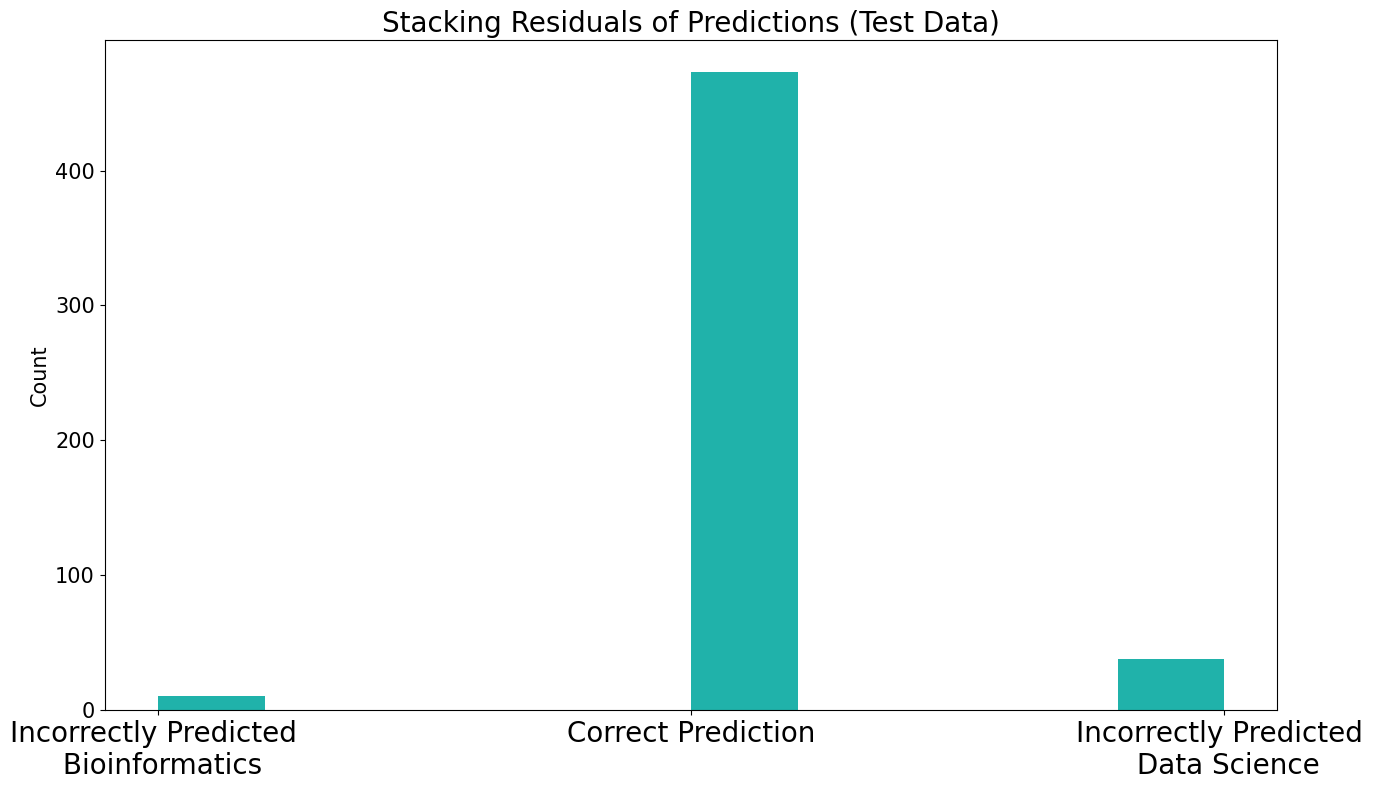

In [11]:
# Plot the resuduals of the mest model for this notebook
functions_for_modeling.plot_residuals(tb_stem_st, X_test, y_test, 'Stacking', 'st_residuals')

My best model still has an imbalanced error, but the amount of incorrectly predicted Data Science texts is less than in my previous best model - Naive Bayes.

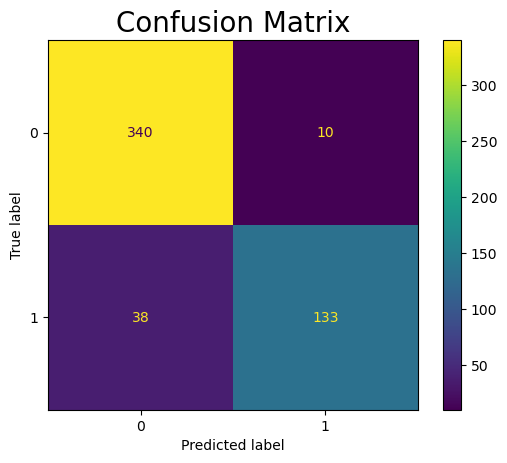

In [12]:
# Confusion Matrix
functions_for_modeling.plot_confusion_matrix(tb_stem_st, X_test, y_test)

Bioinformatics is 1 and Data Science is 0. As we could see in the residual plot, my model wrongly predicts more Bioinformatics texts as Data Science than other way around. This model has 38 False Negatives and only 10 False Positives. It reduced both False Negatives and False Positives compared to the best Naive Bayes model (the best model before).

Stacking improved the F1 score by 0.03, Test Accuracy by 2%, and Cross-Validation score by 1%, overfitting by 0.01 compared to my best stand-alone model (Naive Bayes with Text Blob Tokenizing and Stemming).

---

# Conclusions

My best model for this project is Stacking with Naive Bayes, Gradient Boosting, and XGBoost with Count vectorization and Text Blob Tokenizing and Stemming. It has a high F1 score of 0.85 and a test accuracy of 91%, which is a great improvement from my baseline model with 67%. My model still has predicted 48 texts wrong, mostly assigning Data Science to Biostatistics texts.
I would recommend training my best model with a broader specter of data from different websites and using more Bioinformatics data to battle imbalanced errors in predictions for further development of the model to differentiate Bioinformatics texts from Data Science texts. Stacking brought only moderate improvement to the Naive Bayes model, I would consider time constraints, as Naive Bayes by itself fits much faster and for the huge amount of data it might be crucial to reduce time, in that case, I would recommend Naive Bayes Text Blob Tokenizer and Stemmer.